### Introduction 
In this exercise you will work with stock market data. We use the data available at [Yahoo Finance](https://finance.yahoo.com/quote/DAX/history?period1=1478390400&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)
You will build sequential models to predict the variations for Global X DAX Germany ETF (DAX). The goal is to predict whether the stock value is higher or lower than its actual value of previous day.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout, BatchNormalization

### Loading and Preprocessing Data

In [2]:
# Load dataset
#path="https://github.com/murpi/wilddata/blob/master/quests/dax/"
path="https://raw.githubusercontent.com/murpi/wilddata/master/quests/dax/"

In [3]:
# Loading training data
#training_data = pd.read_csv(path + "dax_train_2019.csv.txt", )
file= path+'dax_train_2019.csv.txt'
#file = '/work/dax_train_2019.csv'
training_data = pd.read_csv(file)
print(f"Training data column info:\n {training_data.dtypes}")
print(f"Training data shape is {training_data.shape}")

Training data column info:
 date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Training data shape is (644, 7)


In [4]:
training_data

,date,open,high,low,close,adj_close,volume
0,2016-11-07,24.340000,24.440001,24.304001,24.400000,22.092239,2700
1,2016-11-08,24.559999,24.559999,24.520000,24.530001,22.209948,1100
2,2016-11-09,24.296000,24.610001,24.296000,24.590000,22.264271,900
3,2016-11-10,24.750000,24.750000,24.360001,24.474001,22.159245,4600
4,2016-11-11,24.410000,24.537001,24.410000,24.440001,22.128456,2700
...,...,...,...,...,...,...,...
639,2019-05-24,26.054001,26.054001,26.054001,26.054001,25.097227,100
640,2019-05-28,26.166000,26.166000,26.061001,26.100000,25.141537,1600
641,2019-05-29,25.660000,25.799000,25.374001,25.448999,24.514442,3800
642,2019-05-30,25.719999,25.924000,25.719999,25.801001,24.853516,6800


In [5]:
# Loading testing data
testing_data = pd.read_csv(path + "dax_test_2019.csv.txt", sep=",")
print(f"Testing data column info:\n {testing_data.dtypes}")
print(f"Testing data shape is {testing_data.shape}")

Testing data column info:
 date          object
open         float64
high         float64
Low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Testing data shape is (148, 7)


####  Are there any NaN values in training and testing data sets?

In [6]:
training_data.isna().sum().sum(), testing_data.isna().sum().sum()   # there are no NaN values

(0, 0)

#### Preprocessing the data, extracting the features, and normalising the features using `preprocessing.MinMaxScaler` function from sklearn

We have provided you with the relevant function here. But we expect you to explore the data generated. 

What are the shapes?

Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

Optional: Extend the function to include more features - and change it 
to choose a different column as target, i.e. adj_close


In [7]:
# Limiting the training and testing data to "open" column 
training_data_processed = training_data.iloc[:, 1:2].values
testing_data_processed = testing_data.iloc[:, 1:2].values

In [8]:
training_data_processed.shape

(644, 1)

In [9]:
# now let's do it all in a function. extra parameter 'target_column' added
def create_features_labels(training_data, testing_data, scaler=MinMaxScaler(feature_range = (0, 1)), sequence_length=60, target_column='open'):
    """
    Create feature and labels from training data
    :param training_data
    :param testing_data
    :param sequence_length
    :param scaler
    :return: Features and labels sets, and labels bins
    """
    features_set = []
    labels = []
    labels_bin = []
    test_features = []
    # Limiting the training and testing data to relevant column (default to "open" column)
    # training_data_processed = training_data.iloc[:, 1:2].values
 
    training_data_processed = training_data.loc[:, [target_column]].values
    
    # Normalization: Transform features by scaling each feature in training to be in a range of (0, 1)
    training_data_processed = scaler.fit_transform(training_data_processed)
    # Preparing training data features and labels
    for i in range(sequence_length, len(training_data)):
        features_set.append(training_data_processed[i-sequence_length:i, 0])
        labels.append(training_data_processed[i, 0])
        # Fill binary labels
        if training_data_processed[i,0] > training_data_processed[i-1,0]:
            labels_bin.append(1)
        else:
            labels_bin.append(0)
    # Preparing the testing data features
    total = pd.concat((training_data[target_column], testing_data[target_column]), axis=0)
    test_inputs = total[len(total) - len(testing_data) - sequence_length:].values
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    for i in range(sequence_length, len(test_inputs)):
        test_features.append(test_inputs[i-sequence_length:i, 0])
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    features_set, labels, labels_bin = np.array(features_set), np.array(labels), np.array(labels_bin)
    return np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1)), labels, labels_bin, test_features, scaler

In [10]:
features_set, labels, labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), 60, target_column='open')


In [11]:
features_set.shape,labels.shape, labels_bin.shape, test_features.shape

((584, 60, 1), (584,), (584,), (148, 60, 1))

In [12]:
# What are the shapes of the data?
# Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

label_error=False
for i in range(len(labels)-1):
    if labels[i] != features_set[i+1][features_set.shape[1]-1]:
        print(labels[i], features_set[i+1][features_set.shape[1]-1])
        label_error = True

if ~label_error:
    print("labels are all good!")


labels are all good!


### Model
In this section we ask you to build and train a LSTM neural network and use it predict the stock price variations on your testing data.

In [13]:
def lstm_model(input_shape):
  #write code here
  #for simplicity you can use the default stateful argument in the LSTM layer and not worry about this argument here
  model = Sequential()
  model.add(LSTM(50, input_shape=input_shape, activation='tanh'))
  # Adding regularization (BatchNormalization + Dropout)
  #model.add(BatchNormalization())
  model.add(Dropout(0.2))

  # Output layer (1 unit)
  # No activation function -> this is a regression problem
  model.add(Dense(units=1))

  return model

In [14]:
model= lstm_model(input_shape=(features_set.shape[1],1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


Compile your model, train it and evaluate it. 

What is your mse - and what is your accuracy (note that you have two different types of labels readily available to you). 



In [15]:
# Compile Code here

# =============================================================================
# Compile and train model
# =============================================================================

from tensorflow.keras.optimizers import Adam

# use adam with lr 0.001
optimizer = Adam(lr=0.001)

# use metrics 'mean_absolute_percentage_error'
metrics = ["mean_absolute_percentage_error"]

loss = "mean_squared_error"

model.compile(
    optimizer=optimizer,
    metrics=metrics,
    loss=loss
)


In [16]:
# fit (train) the model

# use 100 epochs, 64 batch size, 
batch_size = 64
epochs = 100

History = model.fit(
    x=features_set,
    y=labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    shuffle=False
    )

Epoch 1/100
8/8 [==============================] - 4s 276ms/step - loss: 0.2456 - mean_absolute_percentage_error: 91.0816 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 754224.1250
Epoch 2/100
8/8 [==============================] - 0s 47ms/step - loss: 0.0480 - mean_absolute_percentage_error: 37.4294 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 1549528.5000
Epoch 3/100
8/8 [==============================] - 0s 59ms/step - loss: 0.0128 - mean_absolute_percentage_error: 20.3713 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 1620234.2500
Epoch 4/100
8/8 [==============================] - 0s 52ms/step - loss: 0.0088 - mean_absolute_percentage_error: 18.4797 - val_loss: 0.0059 - val_mean_absolute_percentage_error: 1281973.6250
Epoch 5/100
8/8 [==============================] - 0s 58ms/step - loss: 0.0095 - mean_absolute_percentage_error: 14.7847 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 1226634.2500
Epoch 6/100
8/8 [============================

In [17]:
#Make predictions and inverse the scaling

# finish the code 
predicted_stock_price = model.predict(test_features)
predicted_stock_price_inverse = scaler.inverse_transform(predicted_stock_price)


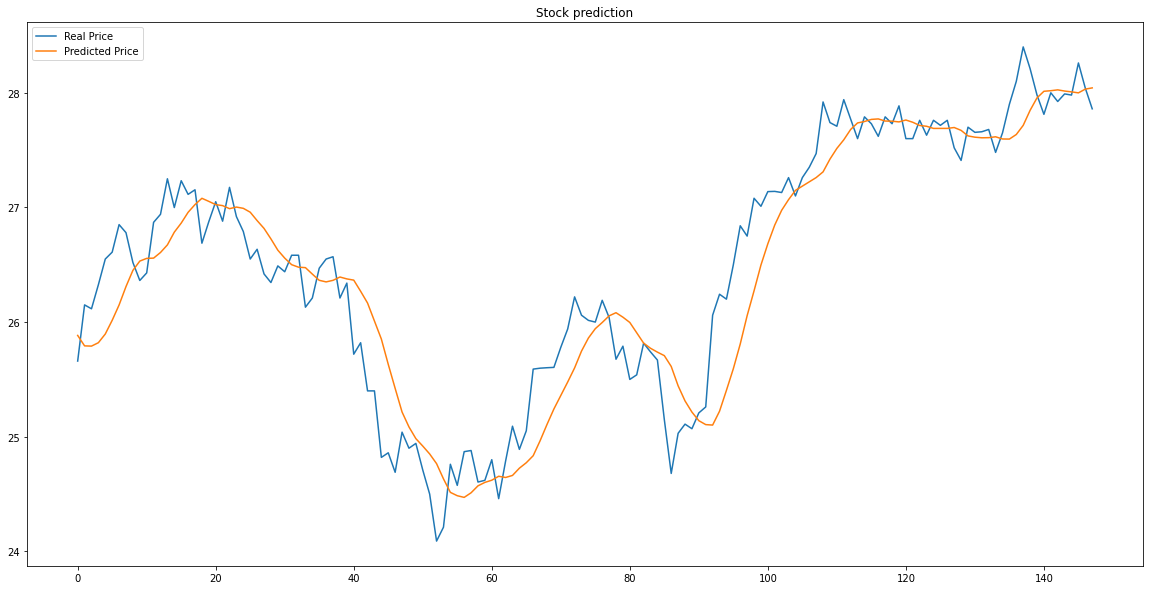

In [18]:
#Plot predictions vs. reality on Test Data
plt.figure(figsize=(20,10))
plt.plot(testing_data_processed, label = 'Real Price')
plt.plot(predicted_stock_price_inverse, label = 'Predicted Price')
#plt.plot(testing_data_processed - predicted_stock_price_inverse, label = 'diff')
plt.title('Stock prediction')
plt.legend()
plt.show()

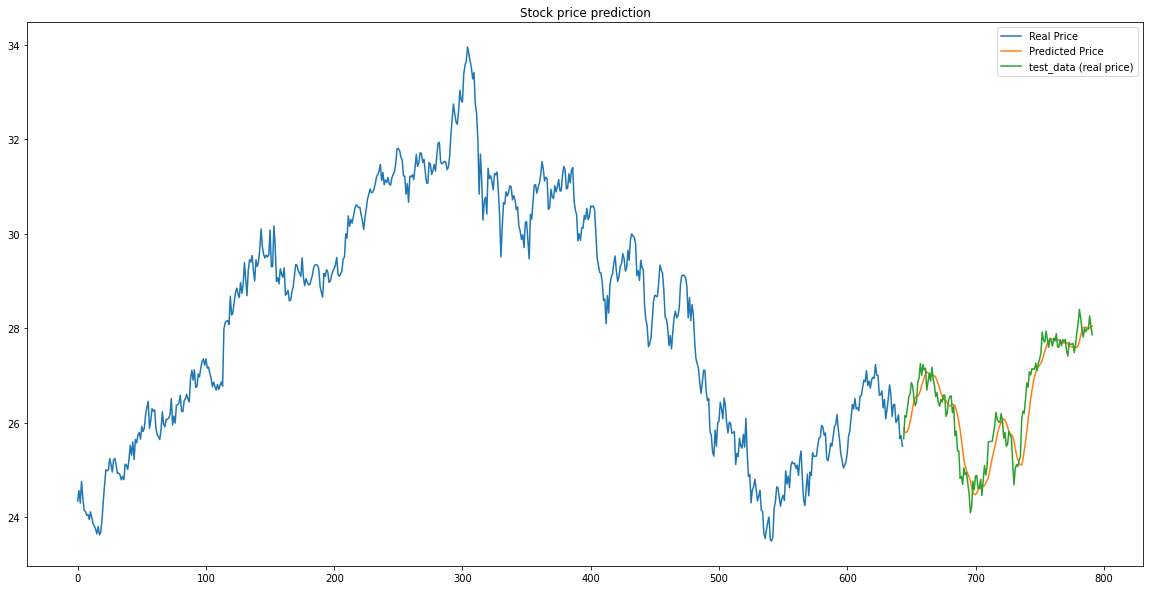

In [19]:
# Plot the whole Stock Price time series, including train and forecasted test

#Create DataFrame for easy plotting
df1 = pd.DataFrame(training_data_processed, columns=['Real'])
index = np.arange(len(training_data_processed),len(training_data_processed)+len(predicted_stock_price_inverse))
df2 = pd.DataFrame(predicted_stock_price_inverse, columns=['Predicted'], index=index)
df2['test_data'] = testing_data_processed
df = df1.merge(df2, how='outer', left_index=True, right_index=True)

#Plot "in time"
plt.figure(figsize=(20,10))
plt.plot(df['Real'], label = 'Real Price')
plt.plot(df['Predicted'], label = 'Predicted Price')
plt.plot(df['test_data'], label = 'test_data (real price)')
plt.title('Stock price prediction')
plt.legend()
plt.show()

Optional: Try your model with more features, try with different sequence lengths (this is a hyperparameter) - and try with the "real" Dax Performance Index data also provided (which reaches back longer). If you do so, you will have to split the data into training and test sets first). 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a109ea11-a7da-42aa-8af0-3a0cdafc917e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>